In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/temperature-readings-iot-devices/IOT-temp.csv


In [ ]:
## DATA DESCRIPTION ##

#Importing Librarirs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import datetime
from datetime import date,datetime
import keras, keras_tuner
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import hyperparameters

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [ ]:
#Reding the dataset
raw_data=pd.read_csv('/kaggle/input/temperature-readings-iot-devices/IOT-temp.csv', sep=',', engine='python',encoding='Latin-1')

#Removing non-essential Data
data=raw_data.drop(['id', 'room_id/id'], axis=1)

In [ ]:
#Creating a DataFrame with Inside Sensor Readings Only
in_only = data[data.iloc[:,2]=='Out'].index
data_in = data.drop(in_only, axis = 0)
data_in = data_in.drop(['out/in'], axis = 1)
data_in['noted_date'] = pd.to_datetime(data_in['noted_date'], format = '%d-%m-%Y %H:%M')

#Creating a DataFrame with Outside Sensor Readings Only
out_only = data[data.iloc[:,2]=='In'].index
data_out=data.drop(out_only, axis = 0)
data_out = data_out.drop(['out/in'], axis = 1)
data_out['noted_date'] = pd.to_datetime(data_out['noted_date'], format = '%d-%m-%Y %H:%M')

<Axes: title={'center': 'Temperature Detected by External IOT Sensor'}, xlabel='Date', ylabel='Temperature'>

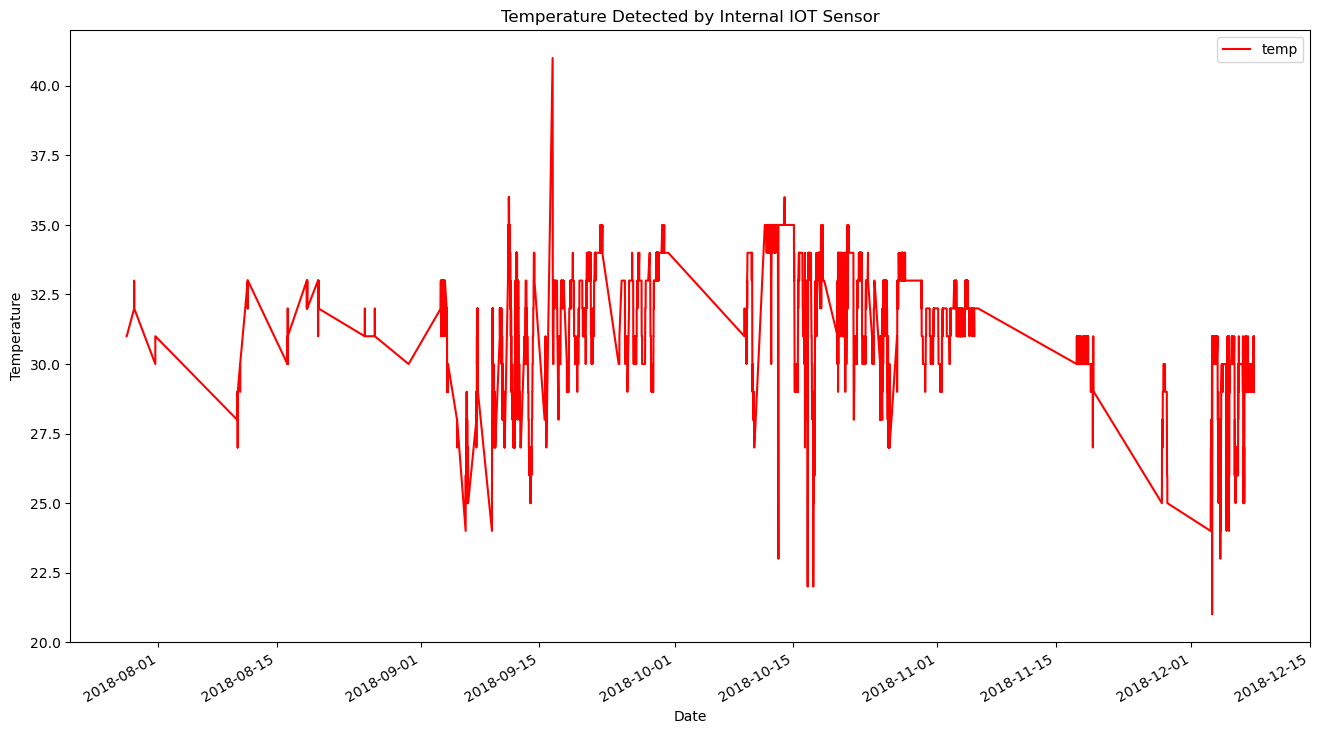

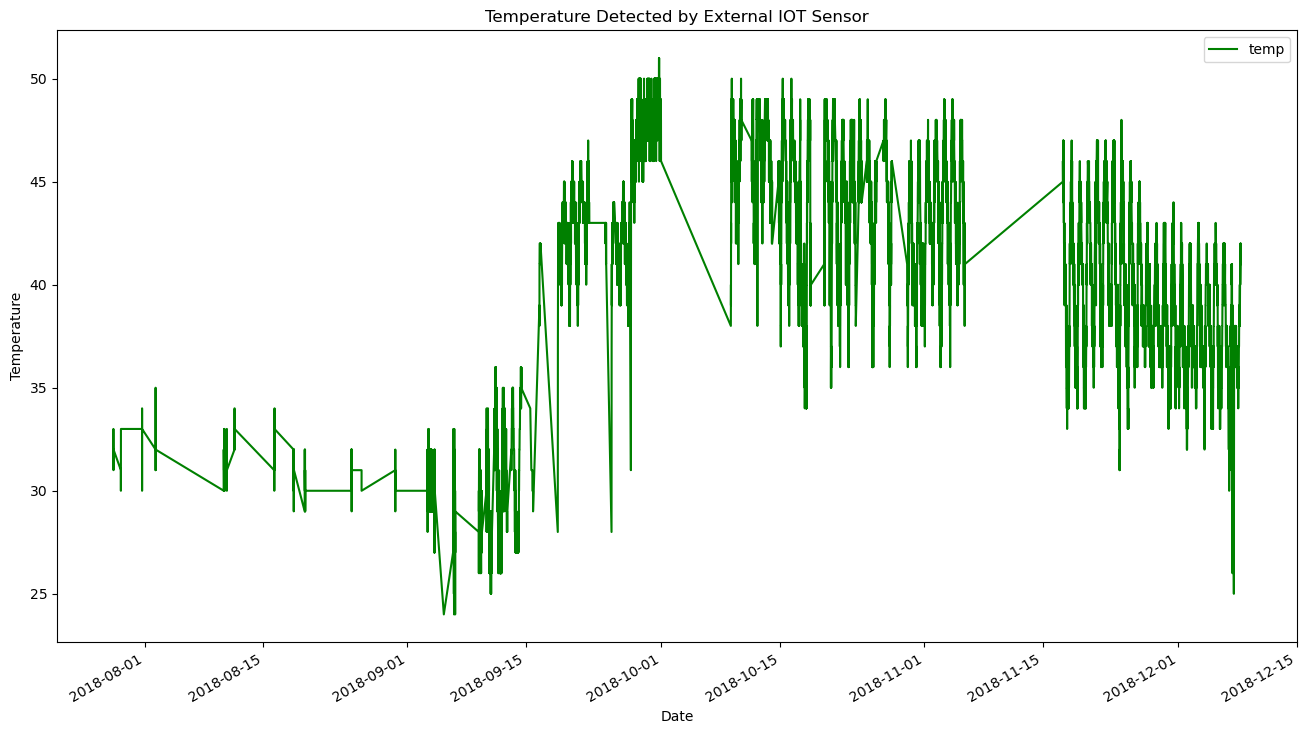

In [ ]:
#Plotting the Temperature Readings
data_in.plot('noted_date','temp', kind = 'line', figsize = (16,9), xlabel = 'Date', ylabel = 'Temperature', title = 'Temperature Detected by Internal IOT Sensor', color = 'Red')
data_out.plot('noted_date','temp', kind = 'line', figsize = (16,9), xlabel = 'Date', ylabel = 'Temperature', title = 'Temperature Detected by External IOT Sensor', color = 'Green')

In [ ]:
## BEST MODEL PREDICTION ##

#Getting the Temperature Readings
in_temp_raw = np.array(data_in.iloc[:,1 : 2].values, dtype = 'float64')
out_temp_raw = np.array(data_out.iloc[:,1 : 2].values, dtype = 'float64')

#Data Scaling
from sklearn.preprocessing import MinMaxScaler
all_temps = (np.array(data['temp'])).reshape(-1,1)
sc = MinMaxScaler(feature_range = (0,1)).fit(all_temps)
in_temp = sc.transform(in_temp_raw)
out_temp = sc.transform(out_temp_raw)
#in_temp = in_temp_raw
#out_temp = out_temp_raw

#Creating a Function for Data Train - Test Split
def IOT_INPUT_DATA (data, test_percent):
    #from sklearn.preprocessing import MinMaxScaler
    #sc = MinMaxScaler(feature_range = (0,1))
    #data = sc.fit_transform(data)
    #from sklearn.model_selection import train_test_split
    #data_train, data_test = train_test_split(data, test_size = float(float(test_percent) / 100))
    limit = int(((100 - test_percent)/100)*len(data))
    data_train = data[:limit]
    data_test = data[limit : len(data)]
    return data_train, data_test

#Creating a Function to get Number of Look Back Values
def IOT_LOOK_BACK (data_train,units):
    x_train = []
    y_train = []
    for i in range (int(units) , len(data_train)):
        x_train.append(data_train[i- int(units): i, 0])
        y_train.append(data_train[i, 0])
    x_train = np.array(x_train, dtype = 'float64')
    y_train = np.array(y_train, dtype = 'float64')
    x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train

#Creating a Function to get the Best Fit RNN
def IOT_RNN(x_train, y_train, layers, max_units_per_LSTM, max_dropout_range, max_trials, epochs, batch_size):
    def iot_rnn(hp):
        iot_rnn = Sequential ()
        iot_rnn.add(LSTM(units = hp.Int('Input_LSTM_Units', min_value = 1, max_value = int(max_units_per_LSTM), step =1), return_sequences = True, input_shape = (x_train.shape[1], 1)))
        iot_rnn.add(Dropout(rate = hp.Float('Input_Dropout',min_value = 0.1, max_value = float(max_dropout_range), step =0.05)))
        for l in range (0,int(layers)-3):
            LSTM_layer_units = str ('Hidden_LSTM_Layer_'+str(l+1)+'_units')
            Dropout_value = str('Hidden_Dropout_Layer_'+str(l+1)+'_value')
            iot_rnn.add(LSTM(units = hp.Int(str(LSTM_layer_units), min_value = 1, max_value = int(max_units_per_LSTM), step =1), return_sequences = True))
            iot_rnn.add(Dropout(rate = hp.Float(str(Dropout_value),min_value = 0.1, max_value = float(max_dropout_range), step =0.05)))
        iot_rnn.add(LSTM(units = hp.Int('Final_LSTM_Layer_Units', min_value = 1, max_value = int(max_units_per_LSTM), step =1), return_sequences = False))
        iot_rnn.add(Dropout(rate = hp.Float('Final_Dropout_Value',min_value = 0.1, max_value = float(max_dropout_range), step =0.05)))
        iot_rnn.add(Dense(1))
        iot_rnn.compile(optimizer = keras.optimizers.Adam(hp.Float('learning_Rate',min_value = 0.001, max_value = 0.01, step =0.00025)), loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
        return iot_rnn
    find_model = RandomSearch(iot_rnn, keras_tuner.Objective('loss', direction = 'min'), max_trials = int(max_trials), directory = 'output', project_name = 'IOT_Temp')
    find_model.search(x_train, y_train, epochs = int(epochs), batch_size = int(batch_size))
    best_model = find_model.get_best_models(1)[0]
    best_parameters = find_model.get_best_hyperparameters(1)[0]
    return best_model,best_parameters

In [ ]:
#Predicting the Best Model for the Outside Sensor
out_train, out_test = IOT_INPUT_DATA (out_temp,  test_percent = 20)
x_train_out, y_train_out = IOT_LOOK_BACK (out_train, units = 5)
best_model_out,best_parameters_out = IOT_RNN(x_train_out, y_train_out, layers = 4, max_units_per_LSTM = 100, max_dropout_range = 0.9, max_trials = 100, epochs = 5, batch_size = 25 )

#Predicting the Best Model for the Inside Sensor
in_train, in_test = IOT_INPUT_DATA (in_temp,  test_percent = 20)
x_train_in, y_train_in = IOT_LOOK_BACK (in_train, units = 5)
best_model_in,best_parameters_in = IOT_RNN(x_train_in, y_train_in, layers = 4, max_units_per_LSTM = 100, max_dropout_range = 0.9, max_trials = 100, epochs = 5, batch_size = 25 )

Trial 100 Complete [00h 02m 28s]
loss: 0.0012855633394792676

Best loss So Far: 0.0006053901161067188
Total elapsed time: 03h 33m 05s


In [ ]:
#Printing the Best Parameters for Each Model
print(best_parameters_out.values)
print(best_parameters_in.values)

{'Input_LSTM_Units': 77, 'Input_Dropout': 0.15000000000000002, 'Hidden_LSTM_Layer_1_units': 95, 'Hidden_Dropout_Layer_1_value': 0.15000000000000002, 'Final_LSTM_Layer_Units': 77, 'Final_Dropout_Value': 0.15000000000000002, 'learning_Rate': 0.00525}
{'Input_LSTM_Units': 77, 'Input_Dropout': 0.15000000000000002, 'Hidden_LSTM_Layer_1_units': 95, 'Hidden_Dropout_Layer_1_value': 0.15000000000000002, 'Final_LSTM_Layer_Units': 77, 'Final_Dropout_Value': 0.15000000000000002, 'learning_Rate': 0.00525}


In [ ]:
#Getting the Model Summary of Each
print(best_model_out.summary())
print(best_model_in.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 77)             24332     
                                                                 
 dropout (Dropout)           (None, 5, 77)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 95)             65740     
                                                                 
 dropout_1 (Dropout)         (None, 5, 95)             0         
                                                                 
 lstm_2 (LSTM)               (None, 77)                53284     
                                                                 
 dropout_2 (Dropout)         (None, 77)                0         
                                                                 
 dense (Dense)               (None, 1)                 7

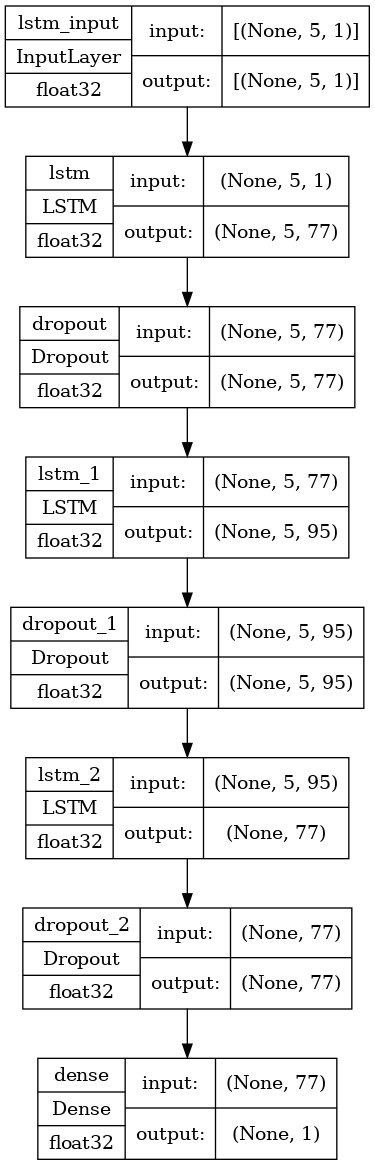

In [ ]:
#Plotting the Best Models
model_name_out = 'IOT_OUTSIDE_TEMP.png'
keras.utils.plot_model(best_model_out, to_file = model_name_out, show_shapes = True, show_dtype = True, show_layer_names = True)
model_name_in = 'IOT_INSIDE_TEMP.png'
keras.utils.plot_model(best_model_in, to_file = model_name_in, show_shapes = True, show_dtype = True, show_layer_names = True)

In [ ]:
## TRAINING AND TESTING ##

#Training the Models
best_model_out.fit(x_train_out, y_train_out, epochs = 100, batch_size = 25 )
best_model_in.fit(x_train_in, y_train_in, epochs = 100, batch_size = 25 )

Epoch 1/100
2473/2473 [==============================] - 25s 8ms/step - loss: 5.7499e-04 - mean_absolute_error: 0.0176
Epoch 2/100
2473/2473 [==============================] - 21s 8ms/step - loss: 5.6635e-04 - mean_absolute_error: 0.0175
Epoch 3/100
2473/2473 [==============================] - 21s 8ms/step - loss: 5.4883e-04 - mean_absolute_error: 0.0171
Epoch 4/100
2473/2473 [==============================] - 21s 9ms/step - loss: 5.4101e-04 - mean_absolute_error: 0.0170
Epoch 5/100
2473/2473 [==============================] - 21s 9ms/step - loss: 5.2781e-04 - mean_absolute_error: 0.0168
Epoch 6/100
2473/2473 [==============================] - 21s 8ms/step - loss: 5.2231e-04 - mean_absolute_error: 0.0167
Epoch 7/100
2473/2473 [==============================] - 21s 9ms/step - loss: 5.1489e-04 - mean_absolute_error: 0.0166
Epoch 8/100
2473/2473 [==============================] - 21s 9ms/step - loss: 5.1195e-04 - mean_absolute_error: 0.0164
Epoch 9/100
2473/2473 [=========================

In [ ]:
#Testing the Models
x_test_out =[]
for i in range( 5, len(out_test)):
    x_test_out.append(out_test[i - 5 :i, 0])
x_test_out=np.array(x_test_out)
x_test_out=np.reshape(x_test_out,(x_test_out.shape[0], x_test_out.shape[1], 1))
predicted_temperature_out_out = best_model_out.predict(x_test_out)
predicted_temperature_out_out = sc.inverse_transform(predicted_temperature_out_out)
predicted_temperature_in_out = best_model_in.predict(x_test_out)
predicted_temperature_in_out = sc.inverse_transform(predicted_temperature_in_out)

x_test_in =[]
for i in range( 5, len(in_test)):
    x_test_in.append(in_test[i - 5 :i, 0])
x_test_in=np.array(x_test_in)
x_test_in=np.reshape(x_test_in,(x_test_in.shape[0], x_test_in.shape[1], 1))
predicted_temperature_out_in = best_model_out.predict(x_test_in)
predicted_temperature_out_in = sc.inverse_transform(predicted_temperature_out_in)
predicted_temperature_in_in = best_model_in.predict(x_test_in)
predicted_temperature_in_in = sc.inverse_transform(predicted_temperature_in_in)

127/127 [==============================] - 0s 3ms/step


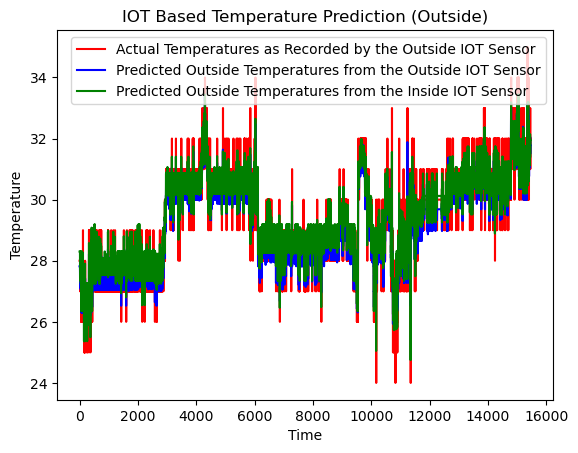

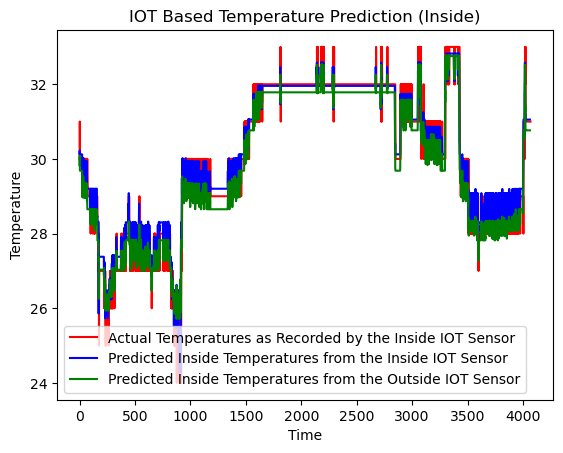

In [ ]:
#Plotting the Test Results
out_test_rescaled = sc.inverse_transform(out_test)
plt.plot(out_test_rescaled, color='r', label = 'Actual Temperatures as Recorded by the Outside IOT Sensor')
#plt.plot(out_test, color='r', label = 'Actual Temperatures as Recorded by the Outside IOT Sensor')
plt.plot(predicted_temperature_out_out, color='b', label = 'Predicted Outside Temperatures from the Outside IOT Sensor')
plt.plot(predicted_temperature_in_out, color='g', label = 'Predicted Outside Temperatures from the Inside IOT Sensor')
plt.title('IOT Based Temperature Prediction (Outside)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

in_test_rescaled = sc.inverse_transform(in_test)
plt.plot(in_test_rescaled, color='r', label = 'Actual Temperatures as Recorded by the Inside IOT Sensor')
#plt.plot(in_test, color='r', label = 'Actual Temperatures as Recorded by the Inside IOT Sensor')
plt.plot(predicted_temperature_in_in, color='b', label = 'Predicted Inside Temperatures from the Inside IOT Sensor')
plt.plot(predicted_temperature_out_in, color='g', label = 'Predicted Inside Temperatures from the Outside IOT Sensor')
plt.title('IOT Based Temperature Prediction (Inside)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()
